In [1]:
from os import getcwd
from os.path import join, abspath

from copy import deepcopy
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from tqdm import tqdm

from src.models.estimator import RFClassifier, relu
from src.models.weights import V1_weights, classical_weights
from src.data.load_dataset import load_mnist

In [2]:
data_dir = abspath(join(getcwd(), '../../'))

In [3]:
# load dataset
train_loader, val_loader, test_loader = load_mnist()
train, test = train_loader.dataset.dataset, test_loader.dataset
train, train_labels = train.data.numpy(), train.targets.numpy()
X_test, y_test = test.data.numpy(), test.targets.numpy()

X_train, X_val, y_train, y_val = train_test_split(train, train_labels, train_size=0.1, stratify=train_labels)


# training params
num_neurons = sorted(set(np.logspace(0, 3.5, 2).astype('int')))
num_trials = 5
nonlinearity = relu
bias = 0
scale = 1
clf = LinearSVC(tol=1e-4, max_iter=1000)
n_jobs=6

# V1 params
compatible = {'s': 5, 'f':2}
incompatible = {'s': 0.5, 'f':0.5}

#### V1 RFNet with optimal parameters $s=5$ and $f=2$

In [4]:
s, f = compatible['s'], compatible['f']
kwargs = {'size':s, 'spatial_freq':f, 'center':None, 'scale':scale}
test_V1 = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    classifiers = [RFClassifier(n, V1_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
    
    test_V1['mean'].append(np.mean(test_accuracy))
    test_V1['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_V1['hidden_size'].append(n)

  0%|          | 0/2 [00:00<?, ?it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
 50%|█████     | 1/2 [00:12<00:12, 12.99s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
100%|██████████| 2/2 [01:13<00:00, 36.90s/it]


#### Classical weights

In [5]:
kwargs = {'scale':scale}
test_classical = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    classifiers = [RFClassifier(n, classical_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
        
    test_classical['mean'].append(np.mean(test_accuracy))
    test_classical['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_classical['hidden_size'].append(n)

  0%|          | 0/2 [00:00<?, ?it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
 50%|█████     | 1/2 [00:11<00:11, 11.29s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
100%|██████████| 2/2 [01:03<00:00, 31.55s/it]


#### Incompatible RFNet with parameters $s=0.5$ and $f=0.5$

In [6]:
s, f = incompatible['s'], compatible['f']
kwargs = {'size':s, 'spatial_freq':f, 'center':None, 'scale':scale}
test_incompatible = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    classifiers = [RFClassifier(n, V1_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
    
    test_incompatible['mean'].append(np.mean(test_accuracy))
    test_incompatible['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_incompatible['hidden_size'].append(n)

  0%|          | 0/2 [00:00<?, ?it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
 50%|█████     | 1/2 [00:19<00:19, 19.93s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
100%|██████████| 2/2 [02:00<00:00, 60.44s/it]


In [7]:
# save
s, f = compatible['s'], compatible['f']
test = {'V1': test_V1, 'classical': test_classical, 'incompatible': test_incompatible}
data_dir = abspath(join(getcwd(), '../../'))
with open(data_dir + '/models/results/mnist_clf/mnist_clf_s=%0.2f_f=%0.2f_estimator.pickle' % (s, f), 'wb') as handle:
    pickle.dump(test, handle, protocol=pickle.HIGHEST_PROTOCOL) 

(0.0, 1000.0)

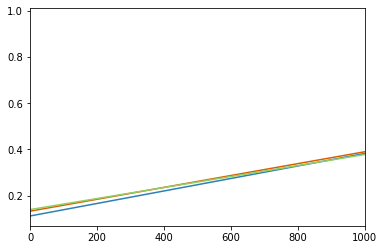

In [8]:
# plot
s, f = compatible['s'], compatible['f']
with open(data_dir + '/models/results/mnist_clf/mnist_clf_s=%0.2f_f=%0.2f_estimator.pickle' % (s, f), 'rb') as file:
    results = pickle.load(file) 

fig = plt.figure()
plt.plot(results['V1']['hidden_size'], results['V1']['mean'], c='#2c7fb8')
plt.plot(results['classical']['hidden_size'], results['classical']['mean'], c='#d95f02')
plt.plot(results['incompatible']['hidden_size'], results['incompatible']['mean'], c='#91cf60')
plt.xlim([0, 1000])